# Data cleaning

Narrow down the list of audio labels to the following classes:
- glass_breaking
- drinking_sipping
- laughing
- coughing
- door_wood_knock
- clock alarm
- crying_baby
- dog
- cat
- footsteps

In [2]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow  

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile


import IPython.display as ipd
import librosa
import librosa.display
import os, time, warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv1D,
    MaxPooling1D,
    BatchNormalization,
    Dropout,
    Flatten,
    Conv2D,
    MaxPool2D,
)

warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("esc50.csv")
df.head()
df.set_index("filename", inplace=True)
df.head()

# using joins to avoid Win/Mac conflicts with backslashes
path = os.getcwd()
audio_ds_path = os.path.join(path, "ESC-50", "audio")

if (os.path.exists(audio_ds_path)):
    print("Audio DS path exists")
if (os.path.isdir(audio_ds_path)):
    print("Audio DS path is a valid directory")

Audio DS path exists
Audio DS path is a valid directory


In [6]:
df.reset_index(inplace=True)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


Keep audio files that only exist in a house

In [7]:
house_sound = [
    'glass_breaking', 'drinking_sipping', 'laughing', 'coughing',
    'door_wood_knock', 'clock_alarm', 'crying_baby', 'dog',
    'cat', 'footsteps'
]

dfs = []

for sound in house_sound:
    sound_df = df[df['category'].str.contains(sound, na=False)]
    dfs.append(sound_df)

house_sound_df = pd.concat(dfs, ignore_index=True)
house_sound_df


,filename,fold,target,category,esc10,src_file,take
0,1-20133-A-39.wav,1,39,glass_breaking,False,20133,A
1,1-84536-A-39.wav,1,39,glass_breaking,False,84536,A
2,1-84704-A-39.wav,1,39,glass_breaking,False,84704,A
3,1-84705-A-39.wav,1,39,glass_breaking,False,84705,A
4,1-85168-A-39.wav,1,39,glass_breaking,False,85168,A
...,...,...,...,...,...,...,...
395,5-244310-A-25.wav,5,25,footsteps,False,244310,A
396,5-263490-A-25.wav,5,25,footsteps,False,263490,A
397,5-263491-A-25.wav,5,25,footsteps,False,263491,A
398,5-263501-A-25.wav,5,25,footsteps,False,263501,A


Note that we have 40 audio samples for each category. 

# MFCC Visualizations

In [7]:
plt.rcParams["figure.figsize"] = (5, 2.5)
plt.rcParams["figure.dpi"] = 200

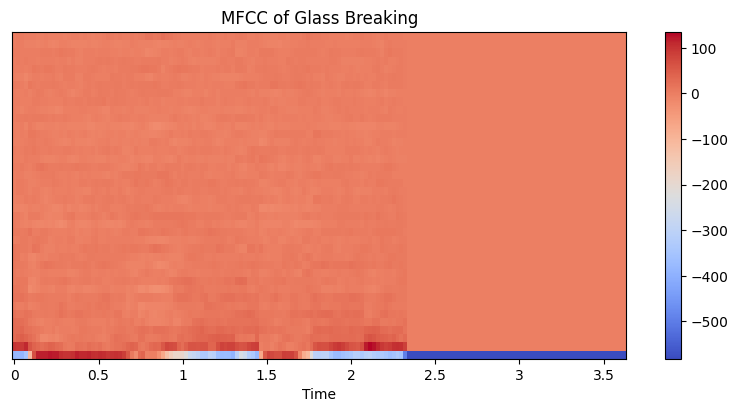

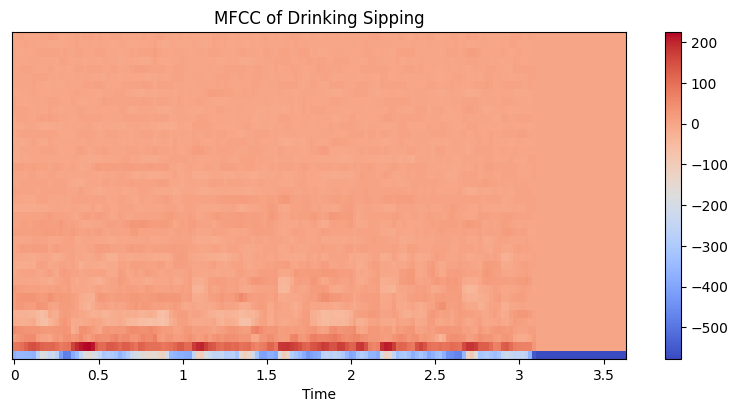

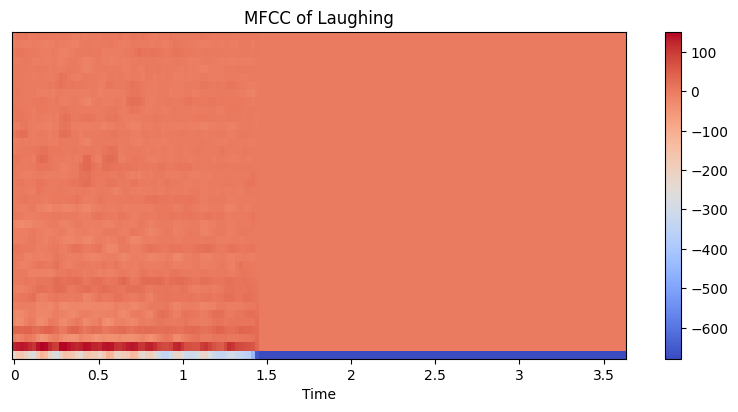

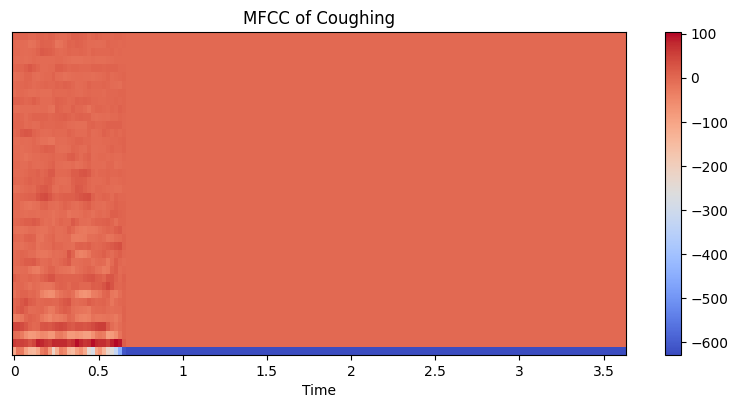

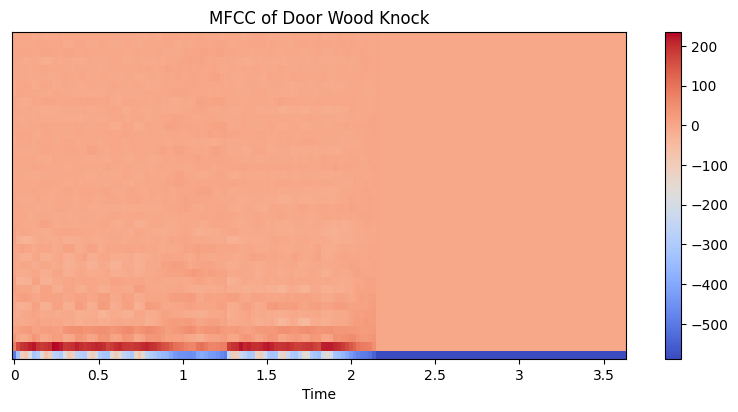

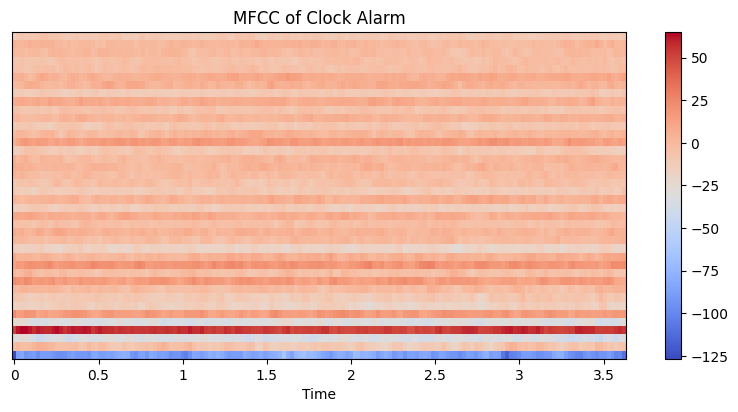

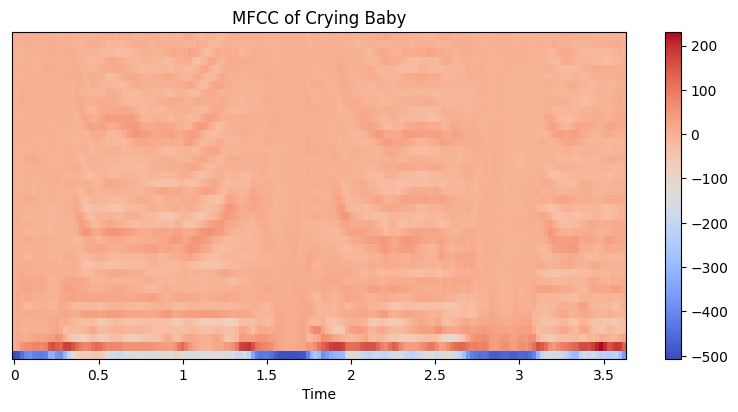

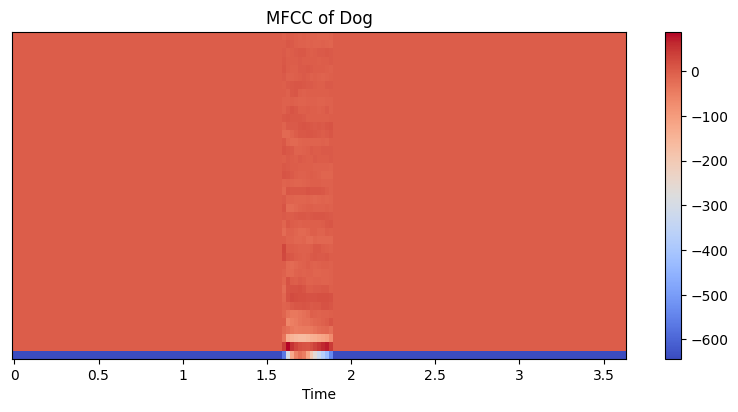

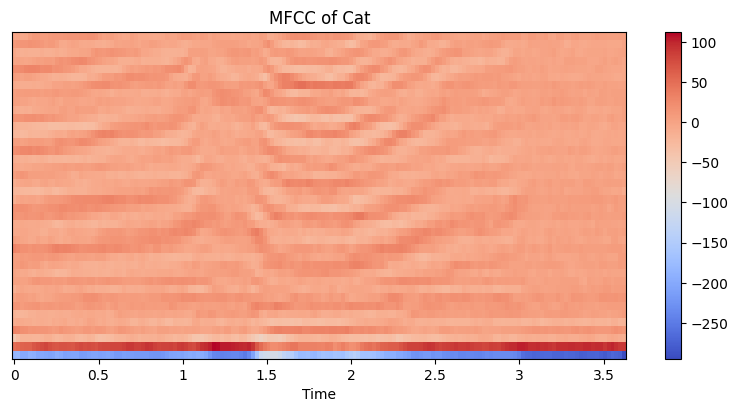

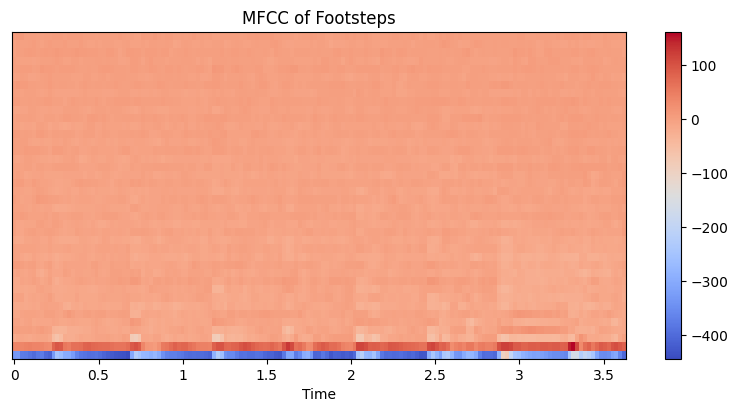

In [8]:
# Extract one of the audio filename from each category
audio_samples = []

# TODO: we don't know yet, but the sampling rate of the INMP441 might be below 22k
# will keep the sampling rate to 16kHz for now
sampling_rate = 16000

# Extract one filename per category
for category in house_sound_df['category'].unique():
    category_df = house_sound_df[house_sound_df['category'] == category]
    audio_path = os.path.join(audio_ds_path, category_df['filename'].iloc[0])
    audio_samples.append((category, audio_path))

# Plot MFCC for each category
for category, audio_path in audio_samples:
    xf, sr = librosa.load(audio_path, sr=sampling_rate)
    
    mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
    
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(mfccs, x_axis="time")
    plt.colorbar()
    plt.tight_layout()
    
    # Format category nicely
    formatted_category = category.replace('_', ' ').title()
    plt.title(f"MFCC of {formatted_category}")
    
    plt.show()


# Feature Extraction and Database Building

## Extract MFCC Features

In [9]:
# list containing all the features
extracted = []

# for loop to extract features from each audio file
for index, row in tqdm(house_sound_df.iterrows(), total=house_sound_df.shape[0]):
    category = row['category']
    filename = row['filename']
    audio_path = os.path.join(audio_ds_path, filename)
    
    # Load the audio file
    xf, sr = librosa.load(audio_path, sr=sampling_rate)
    
    # Extract MFCC features
    mfccs = librosa.feature.mfcc(y=xf, sr=sr, n_mfcc=40)
    
    # Average the MFCCs across time to get a fixed-size feature vector
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
    # Append the features and label to the extracted list
    extracted.append((mfccs_mean, category))

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [00:04<00:00, 88.07it/s]


## Data Preprocessing

In [10]:
# create a new dataframe
extracted_df = pd.DataFrame(extracted, columns=["feature", "class"])
# Storing the dataframe to pickle for further processing
extracted_df.to_pickle("extracted_df.pkl")

extracted_df.head()

,feature,class
0,"[-296.53723, 31.88038, 12.540399, 12.120707, 5...",glass_breaking
1,"[-384.47397, 23.623476, 5.213662, 3.157329, 4....",glass_breaking
2,"[-498.5105, 10.259198, 5.0914044, 4.2389345, 2...",glass_breaking
3,"[-561.98615, 9.130898, 0.46899444, 1.3111233, ...",glass_breaking
4,"[-543.8533, 10.739928, 16.430054, 13.134332, 1...",glass_breaking


## Distribute the data to X and Y

In [11]:
# create a new dataframe
final = pd.DataFrame(extracted, columns=["feature", "class"])
X = np.array(final["feature"].tolist())
y = np.array(final["class"].tolist())

## Using LabelEncoder() to encode the string labels to an integer

In [12]:
# label encoding to get encoding
le = LabelEncoder()

# transform each category with it's respected label
Y = to_categorical(le.fit_transform(y))
Y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], shape=(400, 10))

## Split the data into train and test sets

In [13]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])

Number of training samples =  320
Number of testing samples =  80


# Model 1 - CNN 1D

## Preprocessing

In [26]:
xTrainval, xTest, yTrainval, yTest = train_test_split(
    X, Y, test_size=0.1, stratify=y, random_state=387
)
xTrain, xvalid, yTrain, yvalid = train_test_split(
    xTrainval, yTrainval, test_size=0.2, stratify=yTrainval, random_state=387
)
print("\nNumber of samples for Train set :", xTrain.shape[0])
print("Number of samples for Validation set :", xvalid.shape[0])
print("Number of samples for Test set :", xTest.shape[0])

xTrain = np.expand_dims(xTrain, axis=2)
xvalid = np.expand_dims(xvalid, axis=2)

xTest = np.expand_dims(xTest, axis=2)


print("Shape of X Train", xTrain.shape)
print("Shape of X Test", xTest.shape)


Number of samples for Train set : 288
Number of samples for Validation set : 72
Number of samples for Test set : 40
Shape of X Train (288, 40, 1)
Shape of X Test (40, 40, 1)


In [22]:
CNN1D_Model = Sequential()
CNN1D_Model.add(
    Conv1D(
        256,
        5,
        strides=1,
        padding="same",
        activation="relu",
        input_shape=(xTrain.shape[1], 1),
    )
)
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=10, activation="softmax"))
CNN1D_Model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 40, 256)        │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 40, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 20, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 10, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_6 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 5, 64)          │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_7 (MaxPooling1D)  │ (None, 3, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 743,370 (2.84 MB)

 Trainable params: 742,858 (2.83 MB)

 Non-trainable params: 512 (2.00 KB)

In [23]:
CNN1D_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

## Training 

In [24]:
# hyperparameters
epochs = 50
batch_size = 32


train_results = CNN1D_Model.fit(
    xTrain,
    yTrain,
    validation_data=(xvalid, yvalid),
    epochs=epochs,
    batch_size=batch_size
)

train_results.history['accuracy']
train_results.history['val_accuracy']
train_results.history['loss']
train_results.history['val_loss']

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.1181 - loss: 2.7107 - val_accuracy: 0.1667 - val_loss: 2.3025
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2222 - loss: 2.1052 - val_accuracy: 0.1667 - val_loss: 2.0328
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2639 - loss: 1.9688 - val_accuracy: 0.2083 - val_loss: 2.0444
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3403 - loss: 1.7952 - val_accuracy: 0.1250 - val_loss: 2.1368
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3646 - loss: 1.7240 - val_accuracy: 0.2083 - val_loss: 1.8854
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3785 - loss: 1.6221 - val_accuracy: 0.1389 - val_loss: 1.9321
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4062 - loss: 1.6149 - val_accuracy: 0.3611 - val_loss: 1.6544
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4167 - loss: 1.5093 - val_accuracy: 0.2778 - val_loss: 1.7944


[2.3024778366088867,
 2.0328428745269775,
 2.0444176197052,
 2.136842966079712,
 1.8854438066482544,
 1.9320534467697144,
 1.6544301509857178,
 1.7944166660308838,
 1.4913980960845947,
 1.5118424892425537,
 1.3980191946029663,
 1.293483853340149,
 1.5356959104537964,
 1.2956963777542114,
 1.1670989990234375,
 1.2244324684143066,
 1.090113878250122,
 1.1054071187973022,
 1.1813313961029053,
 1.067444920539856,
 0.9927917122840881,
 0.9980381727218628,
 1.0858896970748901,
 1.1113524436950684,
 1.0438786745071411,
 1.038489818572998,
 1.0639101266860962,
 0.985183596611023,
 0.9660346508026123,
 0.9795275926589966,
 0.8769609332084656,
 0.9239379167556763,
 0.9583199620246887,
 0.7961512804031372,
 0.861616849899292,
 0.8006417155265808,
 0.7637948393821716,
 0.8638951182365417,
 0.8821752071380615,
 0.8052549362182617,
 0.7787061333656311,
 0.7742903232574463,
 0.8017734885215759,
 0.8571503758430481,
 0.792791485786438,
 0.7738743424415588,
 0.7876560688018799,
 0.8368185758590698,
 0.

## Evaluation

In [ ]:
test_results = CNN1D_Model.evaluate(
    xTest,
    yTest
)

predictions = CNN1D_Model.predict(xTest)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7000 - loss: 1.1139
